<a href="https://colab.research.google.com/github/sandy1990418/Deep_learning/blob/master/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider, FloatSlider
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, concatenate
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics
from tensorflow.keras import losses
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical

#**讀入資料**

In [0]:
# Load dataset
(X_train, y_train0), (X_test, y_test0) = datasets.mnist.load_data()

# Reshape size
X_train = X_train.reshape(-1, 28*28)/ X_train.max()
X_test = X_test.reshape(-1, 28*28)/X_test.max()


# One-hot encoding
y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)

In [27]:
##設定Encoder
##修改dense、activation_function = relu

enc_1 = Dense(190, activation='relu')
##設定Encoder之後的Normal Distribution Sampling
##取Log variance的目的為變異數為恆正的特性，轉換成log variance之後可以有正有負
enc_mean = Dense(2)
enc_log_var = Dense(2)
##設定Decoder
dec_2 = Dense(190, activation='relu')
dec_1 = Dense(784, activation='relu')



#############  Functional API
x = Input(shape=(784,))
enc_x = enc_1(x)

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)


##Define  Sampling Function
def sampling(args):
    ##Standard Normal Distribution
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    ## random_normal function :從標準常態中隨機抽取出指定個數
    epsilon = K.random_normal(shape=(batch, dim))
    ##standard normal distribution  convert to normal distribution 
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


# Sampling function wrapped as a Keras layer
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])


# Define Decoder part of VAE
x_hat = dec_1(dec_2(z))

VAE = Model(x, x_hat)
VAE.summary()


##################  Loss function 
# reconstruction_loss = tf.keras.losses.mse(inputs, outputs)
reconstruction_loss = 784 * losses.mean_squared_error(x, x_hat)

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)

VAE.add_loss(vae_loss)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 190)          149150      input_8[0][0]                    
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 2)            382         dense_10[0][0]                   
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 2)            382         dense_10[0][0]                   
____________________________________________________________________________________________

In [28]:
################### 訓練模型
VAE.compile(optimizer=Adam())

VAE.fit(X_train, X_train, 
        batch_size=32, 
        epochs=25)

Epoch 1/25
1875/1875 [==============================] - 7s 4ms/step - loss: 50.2570
Epoch 2/25
1875/1875 [==============================] - 7s 4ms/step - loss: 47.2346
Epoch 3/25
1875/1875 [==============================] - 7s 4ms/step - loss: 45.9879
Epoch 4/25
1875/1875 [==============================] - 7s 4ms/step - loss: 45.3426
Epoch 5/25
1875/1875 [==============================] - 7s 4ms/step - loss: 44.6125
Epoch 6/25
1875/1875 [==============================] - 7s 4ms/step - loss: 44.2451
Epoch 7/25
1875/1875 [==============================] - 7s 4ms/step - loss: 43.8796
Epoch 8/25
1875/1875 [==============================] - 7s 4ms/step - loss: 43.5897
Epoch 9/25
1875/1875 [==============================] - 7s 4ms/step - loss: 43.3630
Epoch 10/25
1875/1875 [==============================] - 7s 4ms/step - loss: 43.2188
Epoch 11/25
1875/1875 [==============================] - 7s 4ms/step - loss: 43.0544
Epoch 12/25
1875/1875 [==============================] - 7s 4ms/step - los

In [33]:
##encoder summary

VAE_Encoder = Model(x, z_mean)
VAE_Encoder.summary()


Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_10 (Dense)             (None, 190)               149150    
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 382       
Total params: 149,532
Trainable params: 149,532
Non-trainable params: 0
_________________________________________________________________
Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_13 (Dense)             (None, 190)               570       
__________________________________

#**Encoder視覺化**

In [9]:
idx = np.random.randint(X_train.shape[0])
print(f"第 {idx} 圖的 latent 表示為 {VAE_Encoder.predict(X_train[idx: idx+1]).squeeze()}")

第 34647 圖的 latent 表示為 [1.3520708 1.767571 ]


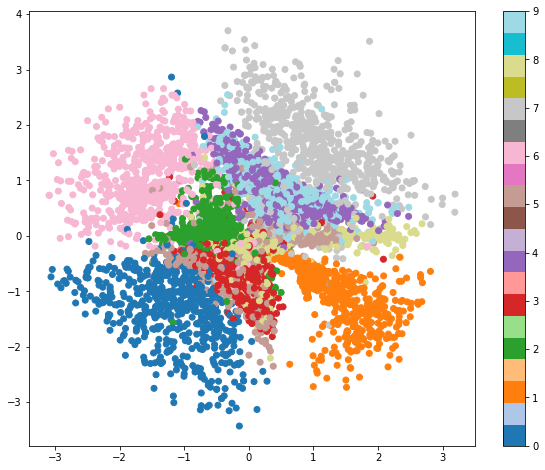

In [16]:
##隨機挑選6500筆，轉換成Latent表示法
indices = np.random.randint(X_train.shape[0], size = 6500)
VAE_latents = VAE_Encoder.predict(X_train[indices])

plt.figure(figsize=(10, 8))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_train0[indices], cmap='tab20')
plt.colorbar()
plt.show()

##**Decoder視覺化**

In [35]:
##decoder summary
z_input = Input(shape = (2,))
VAE_decoder = Model(z_input, dec_1(dec_2(z_input)))
VAE_decoder.summary()


##正規畫函數

def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 2)]               0         
_________________________________________________________________
dense_13 (Dense)             (None, 190)               570       
_________________________________________________________________
dense_14 (Dense)             (None, 784)               149744    
Total params: 150,314
Trainable params: 150,314
Non-trainable params: 0
_________________________________________________________________


In [0]:
##linspace = 在一定範圍內來均勻地撒點
n = 15
digit_size =  28 

grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

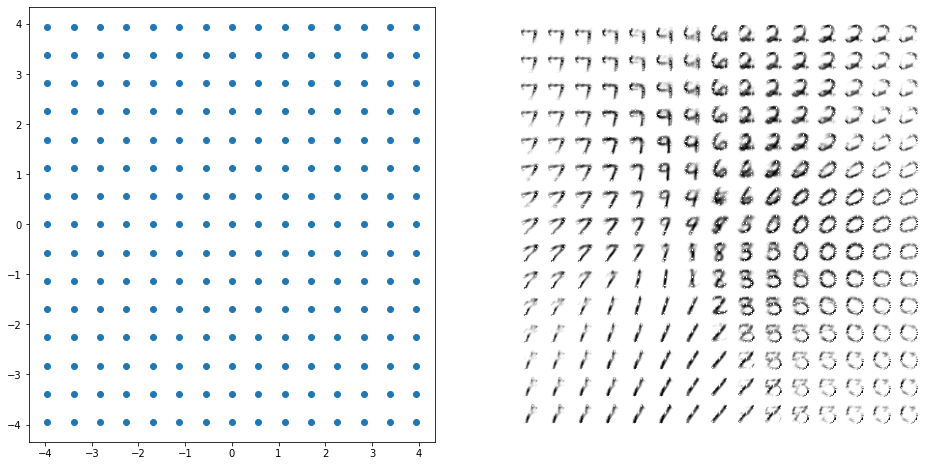

In [42]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
XXX, YYY = np.meshgrid(grid_x_vae, grid_y_vae)
plt.scatter(XXX, YYY)

plt.subplot(1, 2, 2)
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()

##**動態比較**

In [0]:
idx_1, idx_2 = np.random.randint(X_train.shape[0], size=2)

In [0]:
def inBetween(t):
    data_0 = X_train[idx_1].reshape(28, 28)
    data_1 = X_train[idx_2].reshape(28, 28)
    data_t = (1-t)*data_0 + t*data_1
    
    mu_0 = VAE_Encoder.predict(X_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(X_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')
    ax2.set_title('t=0')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='Greys')
    ax3.set_title(f't={t}')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greys')
    ax4.set_title('t=1')

In [49]:
interact(inBetween, t=FloatSlider(value=0, 
                                  min=0, 
                                  max=1.0,
                                  step=0.01,))

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.01), Output()), _dom_classes=('w…

<function __main__.inBetween>